# Accuracy vs. dt

author: steeve.laquitaine@epfl.ch

purpose: find the delta_time that maximizes overall sorting accuracy.
rationale: default delta_time of 0.4 ms might be too conservative, particularly given that the simulator timestamps spikes (when voltage reaches (-10uV) and the spike sorter might be timestamping spike at a different location.

Methods:

* For all pairs of a GT unit and a tested unit we first count how many events are matched within a delta_time tolerance (0.4 ms by default).

* if its due to two methods timestamping action potentials at different locations, we should find one best dt for all cells and not one per cell. So we run the comparison algorithm over all pairs, for each dt.


Conclusion:
* we will increase delta_time from the default 0.4 ms to 1.3 ms, because it maximizes unit accuracy (it doubles it, panel f), while still discarding sorted unit timestamps that could be in the vicinity of the ground truth spike by chance (multiple peaks in the distribution of the max accuracy - accuracy at maximal shift, indicative of chance level matches (peak at 0) and above chance level (other peaks) instead of a single peak at 0 (chance level match, panel g)). 

## Setup

activate spikeinterf...

In [1]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)
from src.nodes.utils import get_config
import spikeinterface as si 
from spikeinterface import comparison

# DATASETS

# BUCCINO 2020 
data_conf, _ = get_config("buccino_2020", "2020").values()
BUCCI_KS3_SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort3"]["output_buttw"]
BUCCI_GT_SORTING_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["output"]

# SILICO MARQUES
data_conf_marques, _ = get_config("silico_neuropixels", "concatenated").values()
GT_SORTING_PATH_marques = data_conf_marques["sorting"]["simulation"]["ground_truth"]["output"]
SFREQ = 40000

# SORTINGS

# kilosort 3.0
KS3_SORTING_PATH_marques = data_conf_marques["sorting"]["sorters"]["kilosort3"]["10m"]["output_buttw_noise_fitd"]


# FIGURE SETTINGS
FIG_SIZE = (1.5, 1.05)
LG_FRAMEON = False  # no legend frame
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 1.1
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["xtick.major.width"] = 0.8 * 1.3
plt.rcParams["ytick.major.width"] = 0.8 * 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 2
plt.rcParams["xtick.minor.size"] = 2 * 2
plt.rcParams["ytick.major.size"] = 3.5 * 2
plt.rcParams["ytick.minor.size"] = 2 * 2

N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent": True, "dpi": 300}  # dpi=300 minimum for publication
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}

2024-06-11 16:17:26,595 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-11 16:17:26,632 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-11 16:17:26,633 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-11 16:17:26,706 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [2]:
def get_accuracy_for_slice(
    GT_PATH,
    SORTED_PATH,
    start_frame,
    end_frame,
    delta_time,
):
    # ground truth
    SortingTrue = si.load_extractor(GT_PATH)
    SortingTrue = SortingTrue.frame_slice(start_frame=start_frame, end_frame=end_frame)

    # sorted
    SortingKS = si.load_extractor(SORTED_PATH)

    # compare
    comp = comparison.compare_sorter_to_ground_truth(
        SortingTrue,
        SortingKS,
        exhaustive_gt=True,
        delta_time=delta_time,
    )
    return comp.agreement_scores.max(axis=1).sort_values(ascending=False).values

### (11m) Compute sorting accuracy vs. dt

first 10 minutes of the recordings

In [3]:
# set test delta_time to test
delta_times = np.arange(0, 30, 0.1)
true_unit_accs = []
tot_accs = []

# test different delta_times
for d_i in delta_times:

    # get each true unit accuracies
    # for this delta_time
    true_unit_acc = get_accuracy_for_slice(
        GT_SORTING_PATH_marques,
        KS3_SORTING_PATH_marques,
        start_frame=0,
        end_frame=10 * 60 * SFREQ,
        delta_time=d_i,
    )
    # store
    true_unit_accs.append(true_unit_acc)

    # store total accuracies by delta_time
    tot_accs.append(sum(true_unit_acc >= 0.8) / len(true_unit_acc))

/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(


/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: Us

### Plot

# KEEP THIS FIGURE FOR THE PAPER

max accuracy (ratio): 0.10878962536023054
best delta time: 1.3 ms


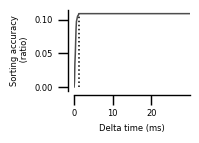

In [8]:
# plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)  # publish
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(delta_times, tot_accs, color=(0.3, 0.3, 0.3))

# legend
ax.set_ylabel("Sorting accuracy\n (ratio)")
ax.set_xlabel("Delta time (ms)")

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.set_xlim((delta_times[0], delta_times[-1]))

# calculate optimal accuracy and delta time
argmax_td = delta_times[np.argmax(tot_accs)]
max_acc = tot_accs[np.argmax(tot_accs)]

# plot optimal delta_time
plt.vlines(x=argmax_td, ymin=0, ymax=max_acc, linestyle=":", color="k")

# print
print("max accuracy (ratio):", tot_accs[np.argmax(tot_accs)])
print("best delta time:", delta_times[np.argmax(tot_accs)], "ms")

# save figure
plt.savefig(
    "figures/6_supp/fig5/svg/acc_vs_dt.svg",
    **savefig_cfg,
)

# References

https://spikeinterface.readthedocs.io/en/0.100.5/modules/comparison.html?highlight=comparison

https://spikeinterface.readthedocs.io/en/0.100.5/api.html?highlight=delta_time#spikeinterface.comparison.compare_two_sorters